# Create Service Key in Google

- Go to Google Cloud Console
- Select Project in top drop down
- Select IAM & Admin in sidebar
- Select Service Accounts in sidebar
- Click Create Service Account button (example name bhereth-wfrcbq) 
- Create account and give permissions
- Select Keys option
- Clcik Add Key button - Create New Key
- Select JSON
- Should receive confirmation that key was created
- Look in 'Downloads' folder for key
- Move file to secure spot on local drive


In [93]:
import os
import pandas as pd
import pandas_gbq
import pytz
import io
from dbfread import DBF

In [94]:
# import value labels to get description of codes

dfValueLabels = pd.read_csv('value_labels.csv')
dfValueLabels

,table,variable,value,label
0,hh,participation_group,1,"Signup survey completed via browserMove, Diary..."
1,hh,participation_group,2,"Signup survey completed via browserMove, Diary..."
2,hh,participation_group,3,"Signup survey completed via browserMove, Diary..."
3,hh,participation_group,4,"Signup survey completed via call center, Diary..."
4,hh,participation_group,5,"Signup survey completed via call center, Diary..."
...,...,...,...,...
2036,trip,imputed_record_type,1,Imputed from proxy
2037,trip,imputed_record_type,2,Imputed school trip from attendance (no host t...
2038,trip,trace_quality_flag,0,No
2039,trip,trace_quality_flag,1,Yes


In [95]:
# read in code labels and filter and clean up for just trip_type and cast as int64
dfTripTypeLabels = dfValueLabels[dfValueLabels['variable']=='trip_type'].copy()
dfTripTypeLabels.rename(columns={'value':'trip_type'}, inplace=True)
dfTripTypeLabels['trip_type'] = dfTripTypeLabels['trip_type'].astype('int64')
dfTripTypeLabels['Trip Type'] = dfTripTypeLabels['trip_type'].astype('str') + '-' + dfTripTypeLabels['label']
dfTripTypeLabels.drop(columns=['table','variable','label'], inplace=True)
dfTripTypeLabels

,trip_type,Trip Type
1890,1,1-Home-based work
1891,2,2-Home-based school
1892,3,3-Home-based shopping
1893,4,4-Home-based personal business
1894,5,5-Home-based other
1895,6,6-Non-home-based work
1896,7,7-Non-home-based non-work
1897,995,995-Missing response


In [96]:
#google cloud big query libaries
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = r"C:\Users\bhereth\confidential-2023-utah-hts-db5335615978.json"
#key_path = r"C:\Users\bhereth\tdm-scenarios-a85044dbbfd3.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)
print ('Success!')

Success!


In [97]:
# CRAFT SQL STATEMENT
# CAST function makes sure value returned is defined as int, to avoid weird precision issues with floats
# To get distances to 2-mile bins use FLOOR(distance_miles / 2) * 2 

strQry1 = """
SELECT 
  trip_type, 
  CAST(FLOOR(distance_miles / 2) * 2 AS INT64) AS distance_miles_2mibin,
  SUM(trip_weight) AS trip_weight_sum
FROM 
  `confidential-2023-utah-hts.20230313.ex_trip`
GROUP BY 
  trip_type, 
  CAST(FLOOR(distance_miles / 2) * 2 AS INT64)
"""

In [98]:
#dfBinnedTripDistance = client.query(strQry1).to_dataframe()
#dfBinnedTripDistance

In [99]:
# AWAITING GLOBBING
# USE TEMP CSV FROM GBQ BROWSER DOWNLOAD

dfBinnedTripDistance = pd.read_csv('bquxjob_1b1667df_18f06fb53f5.csv')
dfBinnedTripDistance = pd.merge(dfBinnedTripDistance, dfTripTypeLabels, on='trip_type')
dfBinnedTripDistance

,trip_type,distance_miles_2mibin,trip_weight_sum,Trip Type
0,7,10.0,46195.137161,7-Non-home-based non-work
1,7,8.0,76585.100138,7-Non-home-based non-work
2,7,0.0,637360.929566,7-Non-home-based non-work
3,7,2.0,378611.422226,7-Non-home-based non-work
4,7,12.0,59553.198315,7-Non-home-based non-work
...,...,...,...,...
969,2,126.0,0.000000,2-Home-based school
970,2,84.0,44.142885,2-Home-based school
971,2,1146.0,17.986077,2-Home-based school
972,2,56.0,2.586812,2-Home-based school


# Plot distributions

In [121]:
# Group by 'trip_type' and 'distance_miles_2mibin' and sum 'trip_weight_sum'
grouped = dfBinnedTripDistance.groupby(['Trip Type', 'distance_miles_2mibin']).agg({'trip_weight_sum': 'sum'}).reset_index()

# Calculate the total weight for each trip type
total_weights = grouped.groupby('Trip Type')['trip_weight_sum'].transform('sum')

# Calculate percentage distribution
grouped['percentage'] = (grouped['trip_weight_sum'] / total_weights) * 100

# only plot below 60 miles
filtered_grouped = grouped[grouped['distance_miles_2mibin'] <= 60].copy()


## Seaborn Plot

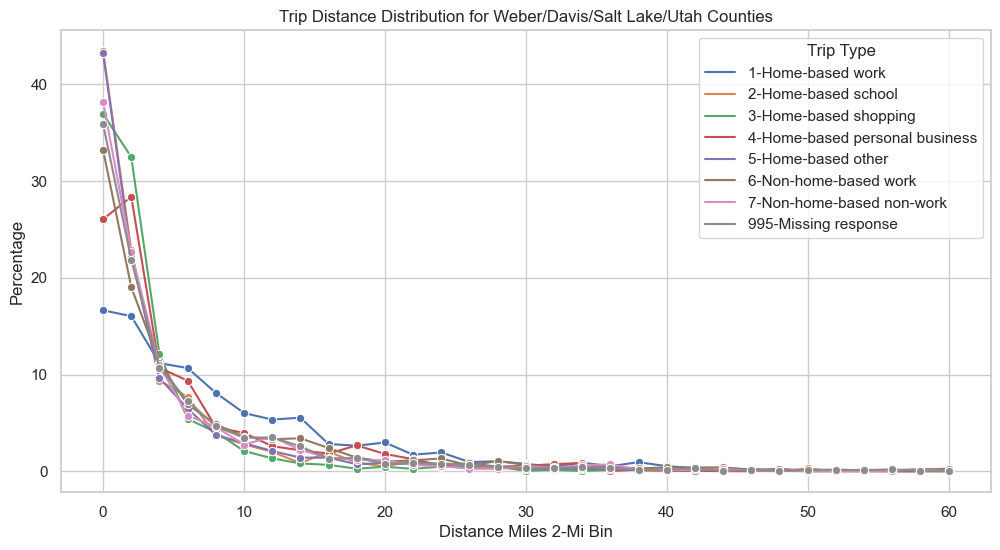

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(12, 6))
# Filter to only include bins up to 100 miles for visualization
line_plot = sns.lineplot(data=filtered_grouped, x='distance_miles_2mibin', y='percentage', hue='Trip Type', marker='o')

# Set labels, title, and limits
plt.xlabel('Distance Miles 2-Mi Bin')
plt.ylabel('Percentage')
plt.title('Trip Distance Distribution for Weber/Davis/Salt Lake/Utah Counties')
plt.legend(title='Trip Type')

# Set x-axis limit if the x-values are numeric and continuous, otherwise ensure your data points are ordered correctly
# plt.xlim(0, 100)

# Show the plot
plt.show()

## Plotly

In [123]:
import plotly.express as px

# Create an interactive line graph
fig = px.line(
    filtered_grouped,
    x='distance_miles_2mibin',
    y='percentage',
    color='Trip Type',
    #markers=True,  # This adds markers to each point
    labels={
        'distance_miles_2mibin': 'Distance Traveled (miles)',
        'percentage': 'Percentage'
    },
    title='Trip Distance Distribution for Weber/Davis/Salt Lake/Utah Counties'
    
)

# Update layout if necessary
fig.update_layout(
    xaxis_title='Distance Traveled (miles)',
    yaxis_title='Percentage of Trips',
    legend_title='Trip Type'
)

# Show the plot
fig.show()

## Plotly Cumulative Distribution

In [108]:
# Assuming 'filtered_grouped' is a DataFrame that has been grouped appropriately
filtered_grouped['cumulative_percentage'] = filtered_grouped.groupby('Trip Type')['percentage'].cumsum()

In [109]:
import plotly.express as px

# Create an interactive line graph for cumulative distribution
fig = px.line(
    filtered_grouped,
    x='distance_miles_2mibin',
    y='cumulative_percentage',
    color='Trip Type',
    labels={
        'distance_miles_2mibin': 'Distance Traveled (miles)',
        'cumulative_percentage': 'Cumulative Percentage'
    },
    title='Cumulative Trip Distance Distribution for Weber/Davis/Salt Lake/Utah Counties'
)

# Update layout if necessary
fig.update_layout(
    xaxis_title='Distance Traveled (miles)',
    yaxis_title='Cumulative Percentage of Trips',
    legend_title='Trip Type'
)

# Show the plot
fig.show()


# Compare HBW distribution by Vehicle Type

In [81]:
# read in code labels and filter and clean up for just fuel_type and cast as int64
# use reference: https://unifiedplan.org/2023-utah-household-travel-survey/core-dataset-guide/#codebook
dfVehTypeLabels = dfValueLabels[dfValueLabels['variable']=='fuel_type'].copy()
dfVehTypeLabels.rename(columns={'value':'fuel_type'}, inplace=True)
dfVehTypeLabels['fuel_type'] = dfVehTypeLabels['fuel_type'].astype('int64')
dfVehTypeLabels['Fuel Type'] = dfVehTypeLabels['fuel_type'].astype('str') + '-' + dfVehTypeLabels['label']
dfVehTypeLabels.drop(columns=['table','variable','label'], inplace=True)
dfVehTypeLabels

,fuel_type,Fuel Type
1045,1,1-Gas
1046,2,2-Hybrid (HEV)
1047,3,3-Plug-in hybrid (PHEV)
1048,4,4-Electric (EV)
1049,5,5-Diesel
1050,6,"6-Other (e.g., natural gas, bio-diesel)"


In [ ]:
# CRAFT SQL STATEMENT
# CAST function makes sure value returned is defined as int, to avoid weird precision issues with floats
# To get distances to 2-mile bins use FLOOR(distance_miles / 2) * 2 

strQry1 = """
SELECT 
  trip_type, 
  CAST(FLOOR(distance_miles / 2) * 2 AS INT64) AS distance_miles_2mibin,
  SUM(trip_weight) AS trip_weight_sum
FROM 
  `confidential-2023-utah-hts.20230313.ex_trip`
GROUP BY 
  trip_type, 
  CAST(FLOOR(distance_miles / 2) * 2 AS INT64)
"""